# Configurazione di Fabry Perot


0.005255758224261655 0.00013552599229604476 16610.50714199981 428.32173345282564
0.005332943422452994 0.00014112123711693784 16854.39234058508 446.00373950212395
0.0051899645392311355 0.0001228428884536408 16402.776986588466 388.2424428973447
0.005260532724933863 0.0001338282382318451 16625.66913145029 422.95792751260836
0.005260532724933863 0.0001338282382318451 16625.66913145029 422.95792751260836
0.005329169656433713 0.00013894234070571573 16842.527636180672 439.11910756608444


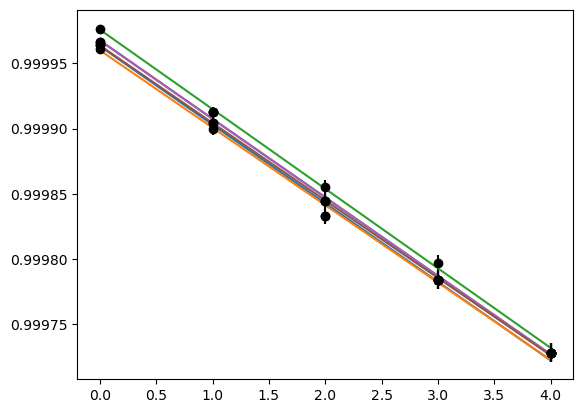

In [2]:
import pandas as pd
import numpy as np

_lambda = 632.8 * 10**(-9)

dati = pd.read_excel("Interferometro.xlsx")

# distanze in metri
#display(dati)
L_focale = 18 * 10**(-3)
distanza_lente_schermo = 1.605

distanza_eff = distanza_lente_schermo - L_focale

raggi = dati["raggio "] * 10**(-2)

angoli = np.arctan(raggi/distanza_eff)

# propagate angloli error
err_raggi = 1/2* 10**(-3)
err_distanza_eff = 5*10**(-3)

dfdx = 1/(1 + (raggi/distanza_eff)**2)
err_angoli = angoli*np.sqrt((dfdx*err_raggi/distanza_eff)**2 + (dfdx*raggi/distanza_eff**2 * err_distanza_eff)**2)

# propagate coseni error
coseni = np.cos(angoli)
err_coseni = np.cos(angoli)*err_angoli

from iminuit import Minuit
from iminuit.cost import LeastSquares

def linear_cost(x, a, b):
    return a + b*x

x = [4,3,2,1,0]

def minimi_quadrati_fit(alfa, beta):
    minimi_quadrati = LeastSquares(x, coseni[alfa:beta], err_coseni[alfa:beta], linear_cost)

    m = Minuit(minimi_quadrati, a=0, b=0)

    m.migrad()
    # label every graph obtained by m.visualize()
    m.visualize()

    d = -1/(2*m.values["b"])*(_lambda)
    err_d = 1/(2*m.values["b"]**2)*m.errors["b"]*(_lambda)

    N_0 = m.values["a"]*2*d/(_lambda)
    err_N_0 = N_0*np.sqrt((m.errors["a"]/m.values["a"])**2 + (err_d/d)**2)
    # print chi normalized
    return d, err_d, N_0, err_N_0

for i in range(0, 5*6, 5):
    fit_data = minimi_quadrati_fit(i, i+5)
    print(fit_data[0], fit_data[1], fit_data[2], fit_data[3])

0.0052758924476930475 1.0591064213984826e-05 16674.136479777273 33.470494229008665
0.0053323679133213215 1.095470715294519e-05 16852.573705647992 34.619541334256375
0.005188289632777583 9.076914663579656e-06 16397.483860362274 28.686036760197084
0.005275880549956416 1.0233817983664986e-05 16674.172513191574 32.34170226144526
0.005275880549956416 1.0233817983664986e-05 16674.172513191574 32.34170226144526
0.005328641420167609 1.0647489585534343e-05 16840.858389328867 33.64883877046556

 0.005273665673261072 4.17746662413128e-06 16667.165389042537 13.201954530995904


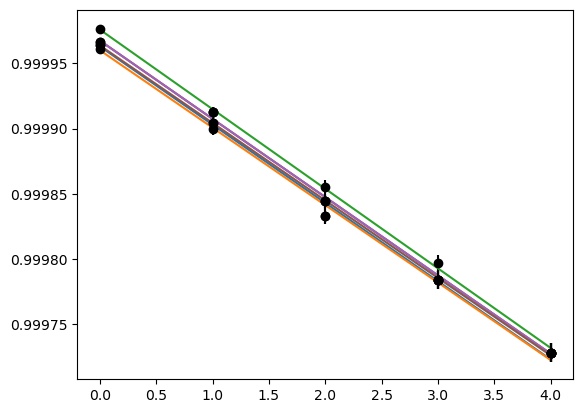

In [3]:
def model(x, N_0, d):
    return N_0*_lambda/(2*d) - x*_lambda/(2*d)

def minimi_quadrati_fit(alfa, beta):
    minimi_quadrati = LeastSquares(x, coseni[alfa:beta], err_coseni[alfa:beta], model)

    m = Minuit(minimi_quadrati, N_0=16600, d=0.0053)

    m.migrad()
    # label every graph obtained by m.visualize()
    m.visualize()

    return m.values["d"], m.errors["d"], m.values["N_0"], m.errors["N_0"]

# calculate weitghed mean of fit_data

d = []
err_d = []
N_0 = []
err_N_0 = []

for i in range(0, 5*6, 5):
    fit_data = minimi_quadrati_fit(i, i+5)
    print(fit_data[0], fit_data[1], fit_data[2], fit_data[3])

    d.append(fit_data[0])
    err_d.append(fit_data[1])
    N_0.append(fit_data[2])
    err_N_0.append(fit_data[3])

# d weighted mean
d = np.array(d)
err_d = np.array(err_d)
N_0 = np.array(N_0)
err_N_0 = np.array(err_N_0)

d_weighted_mean = np.sum(d/err_d**2)/np.sum(1/err_d**2)
err_d_weighted_mean = 1/np.sqrt(np.sum(1/err_d**2))

N_0_weighted_mean = np.sum(N_0/err_N_0**2)/np.sum(1/err_N_0**2)
err_N_0_weighted_mean = 1/np.sqrt(np.sum(1/err_N_0**2))

print("\n", d_weighted_mean, err_d_weighted_mean, N_0_weighted_mean, err_N_0_weighted_mean)

In [4]:
import pandas as pd

dati = pd.read_excel("Interferometro second.xlsx")
display(dati)


,L focale [mm],18,d [micrometri],n frange,raggio,Unnamed: 5,Deltad eff [microm],DeltaN,DeltaN medio,Unnamed: 9,Michelson,Unnamed: 11,Deltad eff m,DeltaN m
0,"d(lente,schermo) [cm]",160.5000,26.0,5.0,3.70,NaN,10.0,27.0,NaN,NaN,"d(lente,schermo) [cm]",167.8,10.0,29.0
1,lamda [microm],0.6328,NaN,NaN,3.30,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,33.0
2,NaN,NaN,NaN,NaN,2.90,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,28.0
3,NaN,NaN,NaN,NaN,2.20,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,29.0
4,NaN,NaN,NaN,NaN,1.35,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,31.0
5,NaN,NaN,46.0,NaN,3.70,NaN,7.0,19.0,NaN,NaN,NaN,NaN,7.0,22.0
6,NaN,NaN,NaN,NaN,3.30,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,21.0
7,NaN,NaN,NaN,NaN,2.90,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,18.0
8,NaN,NaN,NaN,NaN,2.25,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,21.0
9,NaN,NaN,NaN,NaN,1.40,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,20.0


In [5]:
delta_N = np.array(dati["DeltaN"])

def calcola_delta_d(nome_colonna):
    delta_N = np.array(dati[nome_colonna])

    # Calcola delta_d di ciascun set
    delta_d = []
    sigma_delta_d = []

    # Calcola la media di delta_N di ciascun set
    medie_delta_N = []
    sigma_delta_N = []

    # Calcola la media di ciascun set
    # Abbiamo 3 set di 5 valori
    for i in range(0, 3*5, 5):
        current_set = delta_N[i:i+5]

        media_set = np.mean(current_set)
        medie_delta_N.append(media_set)

        err_set = np.std(current_set) / np.sqrt(len(current_set)) # errore della media!
        sigma_delta_N.append(err_set)
    
    delta_d = np.array(medie_delta_N)*_lambda/2 
    sigma_delta_d = np.array(sigma_delta_N)*_lambda/2

    print(medie_delta_N, sigma_delta_N)

    return delta_d, sigma_delta_d

from scipy.stats import t

# test di ipotesi con t di student
def test_t_student(valore_atteso, valore_calcolato, errore, df, alfa=0.05):
    t_calcolato = np.abs(valore_calcolato - valore_atteso) / errore
    t_critico = t.ppf(1-alfa/2, df)
    print(f"t: {t_calcolato:.3} < t critico: {t_critico:.3} ? {t_calcolato < t_critico} \n")

def stampa_risultati(delta_d, sigma_delta_d, nome_aspettazione, alfa):
    for i in range(len(delta_d)):
        valore_atteso = dati[nome_aspettazione][i*5]*10**(-6)
        errore_micrometro = 0.25*10**(-6)
        valore_calcolato = delta_d[i]
        errore = np.sqrt(sigma_delta_d[i]**2 + errore_micrometro**2)

        print(f"Valore atteso: {valore_atteso:.2e} \nValore calcolato: {valore_calcolato:.2e} +- {errore:.2e} \n")

        test_t_student(valore_atteso, valore_calcolato, errore, 4, alfa)
        
delta_d, err_delta_d = calcola_delta_d("DeltaN")
stampa_risultati(delta_d, err_delta_d, "Deltad eff [microm]", 0.05)

[29.4, 20.4, 14.6] [0.7266360849833979, 0.4560701700396552, 0.35777087639996635]
Valore atteso: 1.00e-05 
Valore calcolato: 9.30e-06 +- 3.40e-07 

t: 2.05 < t critico: 2.78 ? True 

Valore atteso: 7.00e-06 
Valore calcolato: 6.45e-06 +- 2.89e-07 

t: 1.89 < t critico: 2.78 ? True 

Valore atteso: 5.00e-06 
Valore calcolato: 4.62e-06 +- 2.74e-07 

t: 1.39 < t critico: 2.78 ? True 



# Configurazione di Michelson

In [6]:
delta_d, err_delta_d = calcola_delta_d("DeltaN m")
stampa_risultati(delta_d, err_delta_d, "Deltad eff m", 0.05)

distanza_lente_schermo = 167.8 * 10**(-2) # metri

# il test è superato con cos(theta) circa 1 come assunzione!

dati_2 = pd.read_excel("Interferometro.xlsx")
display(dati_2)

[30.0, 20.4, 15.4] [0.7999999999999999, 0.606630035524124, 0.4560701700396551]
Valore atteso: 1.00e-05 
Valore calcolato: 9.49e-06 +- 3.56e-07 

t: 1.43 < t critico: 2.78 ? True 

Valore atteso: 7.00e-06 
Valore calcolato: 6.45e-06 +- 3.15e-07 

t: 1.73 < t critico: 2.78 ? True 

Valore atteso: 5.00e-06 
Valore calcolato: 4.87e-06 +- 2.89e-07 

t: 0.441 < t critico: 2.78 ? True 



,L focale mm,18,d micrometri,n frange,raggio,costheta,x,y,Unnamed: 8,Unnamed: 9,...,theta f,deltaN v,media,Unnamed: 26,Righello,Unnamed: 28,"dPt,P0","dP0,Pi",costheta inc,costheta N
0,"d(lente,schermo) cm",160.5000,26.0,5.0,3.70,NaN,0.0,NaN,NaN,NaN,...,2.0,7.0,NaN,NaN,D,129.0,13.8,1.4,NaN,NaN
1,lamda microm,0.6328,NaN,NaN,3.30,NaN,1.0,NaN,NaN,NaN,...,NaN,9.0,NaN,NaN,"dlaser,righello",229.0,NaN,2.1,NaN,NaN
2,spessore vetro mm,5.0000,NaN,NaN,2.90,NaN,2.0,NaN,NaN,NaN,...,NaN,7.0,NaN,NaN,NaN,NaN,NaN,3.6,NaN,NaN
3,NaN,NaN,NaN,NaN,2.20,NaN,3.0,NaN,NaN,NaN,...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,4.6,NaN,NaN
4,NaN,NaN,NaN,NaN,1.35,NaN,4.0,NaN,NaN,NaN,...,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,46.0,NaN,3.70,NaN,NaN,NaN,NaN,NaN,...,3.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,3.30,NaN,NaN,NaN,NaN,NaN,...,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,2.90,NaN,NaN,NaN,NaN,NaN,...,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,2.25,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,1.40,NaN,NaN,NaN,NaN,NaN,...,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
angolo_iniziale = 0 

_lambda = 632.8 * 10**(-9) # metri
d = 5*10**(-3) # metri, dovrebbe essere sulla scheda pasco, l'abbiamo misurata
err_d = 10**(-3) # metri

angoli = np.radians([3, 5, 2])
print(angoli)

delta_N = np.array(dati_2["deltaN v"])

# Calcola la media di delta_N di ciascun set
vec_medie_delta_N = []
sigma_delta_N = []

# Calcola la media di ciascun set
# Abbiamo 3 set di 5 valori
for i in range(0, 3*5, 5):
    current_delta_N = delta_N[i:i+5]

    media_delta_N = np.mean(current_delta_N )
    vec_medie_delta_N.append(media_delta_N)

    err_set = np.std(current_delta_N) / np.sqrt(len(current_delta_N)) # errore della media!
    sigma_delta_N.append(err_set) 

vec_medie_delta_N = np.array(vec_medie_delta_N)
n_vetro = (2*d-vec_medie_delta_N*_lambda)*(1-np.cos(angoli)) \
        / (2*d*(1-np.cos(angoli)) - vec_medie_delta_N*_lambda)

def calcola_n_vetro(d, delta_N, angolo):
    return (2*d-delta_N*_lambda)*(1-np.cos(angolo)) \
         / (2*d*(1-np.cos(angolo)) - delta_N*_lambda)

# define derivative function
def derivative(f, x, dx=1e-6, args=()):
    return (f(x+dx, *args) - f(x, *args))/dx

def dndN(d, delta_N, angolo):
    return derivative(calcola_n_vetro, delta_N, dx=1e-8, args=(d, angolo))

def dndangolo(d, delta_N, angolo):
    return derivative(calcola_n_vetro, angolo, dx=1e-8, args=(d, delta_N))

def dndd(d, delta_N, angolo):
    return derivative(calcola_n_vetro, d, dx=1e-8, args=(delta_N, angolo))

print(vec_medie_delta_N)
print(sigma_delta_N)

print(n_vetro)

err_n_vetro = np.sqrt((dndN(d, vec_medie_delta_N, angoli)*sigma_delta_N)**2 + (dndd(d, vec_medie_delta_N, angoli)*err_d)**2 + (dndangolo(d, vec_medie_delta_N, angoli)*np.radians(0.5))**2)
print(err_n_vetro)

[0.05235988 0.08726646 0.03490659]
[ 7.2 21.2  3.2]
[0.43817804600413285, 0.33466401061363016, 0.17888543819998315]
[1.49734051 1.54243427 1.49762503]
[0.14900506 0.16755811 0.14908088]


In [16]:
#passo righello
d = 10**(-3) # metri

d_Pt_P0 = 13.80 * 10**(-2)
err_d_Pt_P0 = 0.5 * 10**(-3)

D = 1.29
err_D = 1 * 10**(-2) # più grande visto che si usa il metro

# praticamente inutili
d_laser_righello = 2.29
err_d_laser_righello = 5 * 10**(-3)

d_P0_PN = np.array([1.4, 2.1, 3.6, 4.6]) * 10**(-2)
err_d_P0_PN = 1 * 10**(-3)

# L distanza tra P_0 e P_N
# l distanza tra Pt e P_0
L = d_P0_PN
l = d_Pt_P0
err_l = err_d_Pt_P0
err_L = err_d_P0_PN

# considero angoli piccoli
# arctan(x) = x
# cos(x) = 1 - x**2/2
theta_inc = l/(2*D)
theta_N = (L+l/2)/(D)

cos_theta_inc = 1-theta_inc**2/2
cos_theta_N = 1-theta_N**2/2

N = np.array([1, 2, 3, 4])
y = d * (cos_theta_inc - cos_theta_N)

# Propagazione errori fatta a mano
err_y = d/(2*D**2)*np.sqrt(((L*l-L**2)/D*err_D)**2+((l-2*L)*err_L)**2+(L*err_l)**2)
def model(x, lambda_):
    return lambda_*x

minimi_quadrati = LeastSquares(N, y, err_y, model)

m = Minuit(minimi_quadrati, lambda_=630*10**(-9))

m.migrad()
m.hesse()
display(m)

# rimuovo secondo elemento (ha un valore anomalo)
y = np.delete(y, 1)
err_y = np.delete(err_y, 1)
N = np.delete(N, 1)

minimi_quadrati = LeastSquares(N, y, err_y, model)

m = Minuit(minimi_quadrati, lambda_=630*10**(-9))

m.migrad()
m.hesse()
display(m)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 75.43 (χ²/ndof = 25.1)     │              Nfcn = 18               │
│ EDM = 8.38e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lambda_ │  625e-9   │   4e-9    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────┐
│         │ lambda_ │
├─────────┼─────────┤
│ lambda_ │ 1.4e-17 │
└─────────┴─────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.9616 (χ²/ndof = 0.5)     │              Nfcn = 18               │
│ EDM = 4.32e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lambda_ │  634e-9   │   4e-9    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────┐
│         │ lambda_ │
├─────────┼─────────┤
│ lambda_ │ 1.5e-17 │
└─────────┴─────────┘